# 1、完成 OpenCV 图像处理中的视频操作。
要求：熟悉视频操作的 VideoCapture()、VideoWriter()、read()、write()、release()等方法。并利用这些方法完成对电脑摄像设备（摄像头）的调用，采集一段时长小于 10 秒，能够显示自己正面容貌的视频，并将该视频保存生成名为“学号姓名.mp4”的视频文件。请详细注释核心代码。

In [1]:
# 导入opencv包
import cv2 as cv

# 设置相机模块
cap = cv.VideoCapture(0)                                    # 使用设备编号为0的摄像头进行返回视频数据
fourcc = cv.VideoWriter_fourcc(*'XVID')                     # 设置视频编码格式
out = cv.VideoWriter('test.avi', fourcc, 20.0, (640, 480))  # 设置视频输出位置及格式avi，编码方式，视频帧数，视频分辨率

# 视频录制
while(True):                                                # 通过循环方式进行视频采集
    ret, frame = cap.read()                                  # 从cap循环中读取视频帧
    out.write(frame)                                         # 将视频帧写入到需要保存的视频文件
    cv.imshow('frame', frame)                                # 将视频帧在窗口显示
    if cv.waitKey(1) & 0xFF == ord('q'):                     # 通过键盘事件点击q时，跳出视频采集
        break                                                # 中断，跳出循环

cap.release()                                                # 释放摄像头
out.release()                                                # 释放视频流
cv.destroyAllWindows()                                       # 关闭所有窗口

# 2、利用时间序列分析模型 ARIMA 来预测乌鲁木齐未来一个月的AQI 指数。
要求：遵循图 1 中 ARIMA 模型的建模流程，理解模型原理，对给定的 csv 数据进行预处理，通过了平稳性和白噪声检测后，对模型进行定阶，在得到最有ｐ、ｑ值后，建立模型并完成预测任务。
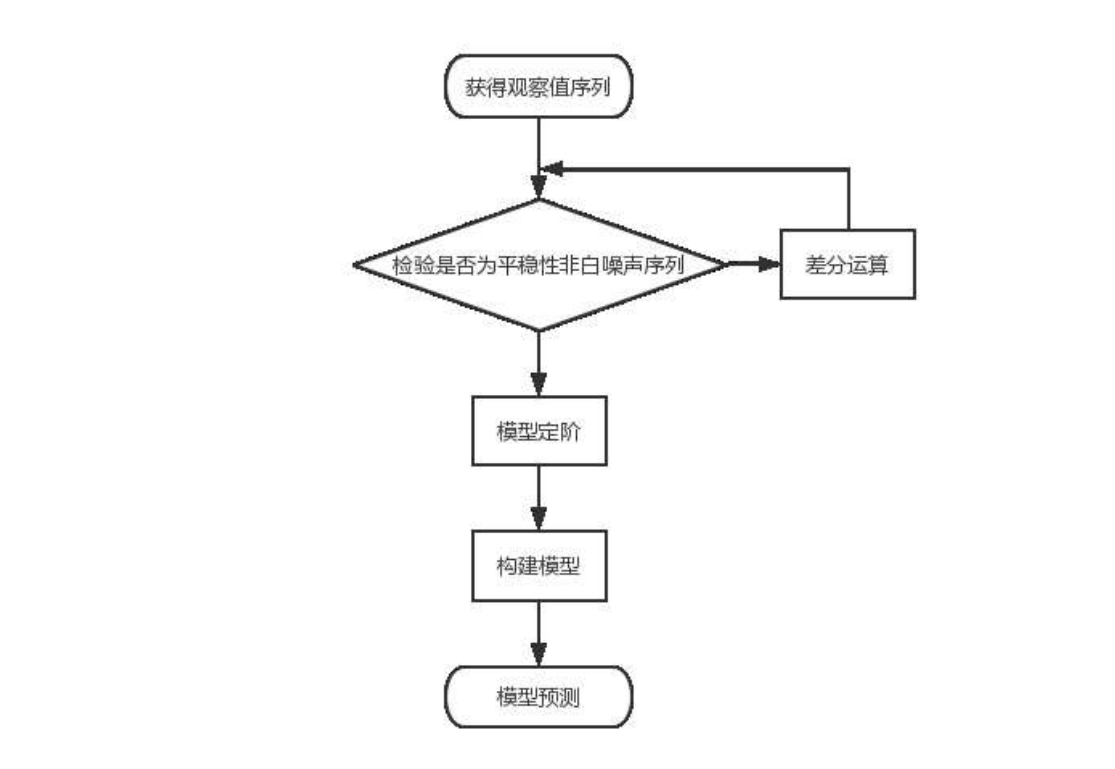

In [2]:
# （1） 数据获取及预处理
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = ['sans-serif'] # 解决中文字体显示问题
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置字体为黑体
import datetime
import statsmodels.api as sm

In [3]:
# 导入数据 通过pd形式读取数据
urumchi_data = pd.read_csv('wulumuqi.csv', encoding = 'utf-8', engine = 'python')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('原始数据为：',urumchi_data) # 打印原始数据
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
原始数据为：             date  AQI  质量等级  PM2.5  PM10  SO2   CO  NO2  O3_8h
0     2014-01-01  196  中度污染    147   208   49  3.9   91     16
1     2014-01-02  184  中度污染    138   179   38  3.5   84     12
2     2014-01-03  248  重度污染    198   287   71  4.2   94     13
3     2014-01-04  251  重度污染    201   250  104  2.6  101      8
4     2014-01-05  132  轻度污染    101   158   41  2.0   73     21
...          ...  ...   ...    ...   ...  ...  ...  ...    ...
1819  2018-12-27  182  中度污染    137   162   13  2.2   62     20
1820  2018-12-28  160  中度污染    122   185    8  2.0   64     25
1821  2018-12-29  129  轻度污染     98   143    8  1.7   61     26
1822  2018-12-30  133  轻度污染    101   178    8  2.3   68     24
1823  2018-12-31  190  中度污染    143   235   10  2.3   71     22

[1824 rows x 9 columns]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [4]:
# 获取 2018 年夏季数据的索引
startIndex = urumchi_data.index[urumchi_data['date'] == '2018-06-01'].tolist()[0]
endIndex = urumchi_data.index[urumchi_data['date'] == '2018-08-31'].tolist()[0]
# 获取2018年夏季的数据，6月到8月的数据作为训练模型
trainUrumchi_data = urumchi_data[startIndex: endIndex+1]
print(trainUrumchi_data)    # 打印6-8月将要进行训练的数据

            date  AQI  质量等级  PM2.5  PM10  SO2   CO  NO2  O3_8h
1610  2018-06-01   63     良     29    76    8  0.7   33    102
1611  2018-06-02   80     良     31   115   10  0.7   40    119
1612  2018-06-03  124  轻度污染      0     0    9  0.6   30    125
1613  2018-06-04   62     良     26    49    8  0.6   20    114
1614  2018-06-05   77     良     24    58   10  0.7   33    132
...          ...  ...   ...    ...   ...  ...  ...  ...    ...
1697  2018-08-27   69     良     20    87    9  0.7   34    102
1698  2018-08-28   64     良     17    40    8  0.7   27    116
1699  2018-08-29   64     良     15    53    8  0.7   29    116
1700  2018-08-30   66     良     11    32    8  0.6   20    119
1701  2018-08-31   43     优     11    38    7  0.7   29     77

[92 rows x 9 columns]


In [5]:
dateData = trainUrumchi_data['date']
AQIData = trainUrumchi_data['AQI']

In [6]:
# 平稳性检测
# 返回值依次为：adf， pvalue p值， usedlag， nobs， critical valuse临界值，icbest，regresults，resstore
# adf 分别大于3种不同检验水平的3个临界值，单位检测统计量对应的p值显著大于0.05
# 说明序列可以判定为 非稳序列
'''
第一行--统计值，用于和下边1%，5% 和10%临界值比较，但更方便的是直接用下边的p值
第二行--p值，即数据不平稳的概率
第三行--延迟
第四行--本次检验用到的观测值个数
第五~七行--1%，5%，10%标准下的临界值
判断平稳性条件，p值小于0.05且adf分别小于3中不同检验水平的3个临界值，因此判断序列为平稳序列
'''

adfresult = sm.tsa.stattools.adfuller(AQIData)  # 使用adfuller方法做平稳性校验
print('原始序列的检验结果为：',adfresult)
# 如果数据结果值低于0.05且adf小于3个不同检验水平的临界值，则序列为平稳序列，反正不平稳，不适合做预测数据
if adfresult[1] < 0.05 and adfresult[0] < adfresult[4]['1%']:
    print('该序列为平稳序列')


原始序列的检验结果为： (-8.735593364757115, 3.106630017839152e-14, 0, 91, {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}, 678.0851705051057)
该序列为平稳序列


In [7]:
'''
白噪声检测
ljungbox_result为tuple格式数据得到的结果：
第1行为ljun-Box统计量
第2行为p值
如果p<0.05，拒绝原假设，说明原始序列存在相关性，则为非白噪声
如果p>=0.05,接受原假设，说明原始序列独立，纯随机，则为白噪声
'''
# 使用sm包中的acorr_ljungbox方法得到白噪声的判断结果
white_noise = sm.stats.diagnostic.acorr_ljungbox(AQIData, lags=1)
print(u'白噪声检测结果：', white_noise)    # 打印白噪声检测结果 
# 值为8.4224768e-256， 因此为非白噪声
# 如果数值小于0.05 为为白噪声数字，可以进行预测，反之不行。
if white_noise.iloc[0,1] < 0.05:
    print(u'这是非白噪声')
else:
    print(u'这是白噪声')

白噪声检测结果：     lb_stat  lb_pvalue
1  0.323774   0.569348
这是白噪声


In [8]:
# 模型定阶
# 对模型进行定阶，得出p与q的值
pmax = int(len(AQIData) /10)  # 一般阶数不超过 length /10
qmax = int(len(AQIData) /10)
bic_matrix = []
# 用迭代方式，以循环形式测试p，q合适的取值
for p in range(pmax + 1):
    temp = []      
    for q in range(qmax + 1):
        try:
            # 由于原始数据平稳，因此差分d为0
            value = sm.tsa.ARIMA(AQIData, order=(p, 0, q)).fit().bic
            temp.append(value)
        except Exception as e:
            # print(e)
            temp.append(None)
    bic_matrix.append(temp)   # 追加合适数据到矩阵
    
bic_matrix = pd.DataFrame(bic_matrix)  # 将其转换成Datafram 数据结构
print(bic_matrix)
# 先使用stack展平成一行数组类型数据， 然后使用idxmin 找出最小值的位置
p,q = bic_matrix.stack().astype(float).idxmax()
print(u'BIC 最小的p值 和 q值: %s，%s' %(p,q))  # BIC 最小的p值和q值

C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-

C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\zny\anaconda3\envs\ML\lib\site-

            0           1           2           3           4           5  \
0  794.826495  798.897733  801.606532  805.795340  810.049526  814.092663   
1  799.024095  802.538804  802.361015  810.244117  814.412610  818.540296   
2  801.584623  805.644788  808.255558  811.166720  813.736387  818.240035   
3  805.687881  810.131610  814.688364  816.031663  819.272023  822.747368   
4  809.975990  814.219111  814.427167  819.195943  818.667954  827.252039   
5  814.040102  818.560713  817.882429  819.795567  823.432063  833.154042   
6  818.557661  822.995889  822.980794  823.008461  827.336356  831.893839   
7  822.232477  826.754274  827.443757  826.263890  832.470167  836.872633   
8  826.754222  830.265296  830.961066  830.092917  835.546260  839.951667   
9  829.408969  833.362146  837.845823  837.792251  841.838037  845.858343   

            6           7           8           9  
0  818.337725  822.593455  822.579079  827.057112  
1  822.801397  822.672402  827.034204  831.54140

C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [9]:
# 建立ARIMA模型
model = sm.tsa.ARIMA(AQIData, order=(p, 0, q)).fit() # 通过ARIMA对AQIData数据进行0阶 模型建立
print(model.summary())                               # 打印数据模型结构

C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                   92
Model:                 ARIMA(9, 0, 9)   Log Likelihood                -384.765
Date:                Wed, 26 Oct 2022   AIC                            809.530
Time:                        18:45:20   BIC                            859.965
Sample:                             0   HQIC                           829.886
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.9864      0.602    124.651      0.000      73.807      76.165
ar.L1         -0.8621      3.189     -0.270      0.787      -7.112       5.388
ar.L2         -0.5182      0.692     -0.749      0.4

C:\Users\zny\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [10]:
# 预测未来一月
# forecase是一个series类型，需要转换为array数据类型
predictions = model.forecast(30)    # 通过时序内容预测未来一个月数据
print(predictions)                  # 打印追加的编号和对应预测的数据
print(type(predictions))            # 打印predictions数据类型
print(np.array(predictions))        # 打印predictions数据第二列
# 预测结果为：
pre_result = np.array(predictions)  # 取第二列
print(u'预测结果为：\n', pre_result)# 打印未来一个月AQI的预测结果

1702    75.954826
1703    89.479945
1704    97.421465
1705    74.966165
1706    66.983951
1707    77.632383
1708    77.370955
1709    80.476423
1710    73.702550
1711    79.130956
1712    88.372058
1713    71.838553
1714    62.954065
1715    72.506016
1716    79.159677
1717    85.655302
1718    75.569315
1719    70.335196
1720    79.801685
1721    72.105965
1722    67.280173
1723    74.151819
1724    79.778580
1725    86.362779
1726    75.332503
1727    64.362587
1728    73.744671
1729    75.037887
1730    74.658599
1731    77.572763
Name: predicted_mean, dtype: float64
<class 'pandas.core.series.Series'>
[75.95482634 89.47994487 97.42146465 74.96616527 66.98395113 77.63238348
 77.37095502 80.47642292 73.70254987 79.13095626 88.37205791 71.83855255
 62.95406518 72.50601555 79.15967734 85.65530219 75.56931468 70.33519629
 79.80168468 72.10596511 67.28017288 74.15181944 79.77858    86.36277915
 75.33250286 64.36258666 73.74467084 75.03788727 74.65859889 77.57276265]
预测结果为：
 [75.95482634 